In [117]:
from typing import List
import warnings

import numpy as np
import geopandas as gpd
import rasterio
import pandas as pd
from shapely.geometry import LineString, Point
from shapely.errors import ShapelyDeprecationWarning
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["font.family"] = "Arial"
from scipy import ndimage

from scrollstats import RASTER_PATHS
from scrollstats import BendDataset, calculate_ridge_metrics, calc_dist
from scrollstats import BendDataExtractor, TransectDataExtractor, RidgeDataExtractor

In [118]:
def rr_to_degrees(p1, p2):
    """Convert rise/run slope to degrees"""
    rise = p2[1] - p1[1]
    run = p2[0] - p1[0]

    rad = np.arctan(rise/run)
    deg = rad*(180/np.pi)
    return deg

In [119]:
def slice_line(ls, start, end) -> LineString:
    """Slice the coords of the input linestring within a given percentage."""

    num_coords = len(ls.coords)
    start_idx = int(start*num_coords)
    end_idx = int(end*num_coords)

    sliced_coords = ls.coords[start_idx:end_idx]
    return LineString(sliced_coords)


In [171]:
bend_id = "LBR_025"
bend_ds = BendDataset(bend_id)
ridges = bend_ds.get_ridges(proj=True)
centerline = bend_ds.get_centerline(proj=True)
bend = bend_ds.get_bend(proj=True)

dem = rasterio.open(RASTER_PATHS[bend_id]["dem"]).read(1)
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"]).read(1)

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_22039/3092837415.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


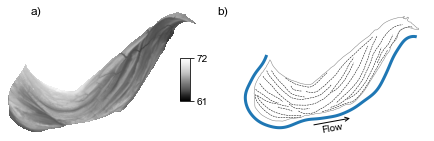

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2))

# DEM
ax1.imshow(dem, cmap="Greys_r")
ax1.set_axis_off()

# DEM colorbar
cax = fig.add_axes([0.42, 0.3, 0.02, 0.3])

cmap = mpl.cm.Greys_r

vmin = np.nanmin(dem)
vmax = np.nanmax(dem)
norm = mpl.colors.Normalize(vmin=vmin, vmax = vmax)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm, cmap),
                    cax=cax,
                    orientation='vertical')



cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(np.round([vmin, vmax]).astype(int))

# Skeleton
ridges.plot(ax=ax2, color="k", lw=0.5, ls="--", label="Ridges")
centerline.plot(ax=ax2, lw=3, label="Centerline")
bend.boundary.plot(ax=ax2, color="grey", lw=0.5)
ax2.set_axis_off()
# ax2.legend(loc="upper left", frameon=False)

# Add flow direction
line_piece = centerline.geometry.apply(lambda x: slice_line(x, 0.45, 0.60))
line_piece = line_piece.geometry.translate(xoff=100, yoff=-50)

p1 = line_piece.geometry[0].coords[0]
p2 = line_piece.geometry[0].coords[-1]
ax2.annotate('', xy=(p2), xytext=(p1), arrowprops=dict(arrowstyle='->', linewidth=1))

anno_coords = line_piece.centroid.translate(xoff=0, yoff=-60)[0].coords[0]
ax2.annotate("Flow", xy=(anno_coords), verticalalignment="center", horizontalalignment="center", rotation=rr_to_degrees(p1, p2))


# Add annotations
plt.text(0.1, 0.9, "a)", transform=fig.transFigure, size=12)
plt.text(0.5, 0.9, "b)", transform=fig.transFigure, size=12)

plt.tight_layout()
plt.savefig(f"BendIntro_{bend_id}.png", dpi=300)

In [188]:
bend_id = "MIS_005"
bend_ds = BendDataset(bend_id)
ridges = bend_ds.get_ridges(proj=True)
centerline = bend_ds.get_centerline(proj=True)
bend = bend_ds.get_bend(proj=True)

dem = rasterio.open(RASTER_PATHS[bend_id]["dem"]).read(1)
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"]).read(1)

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_22039/1062399635.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


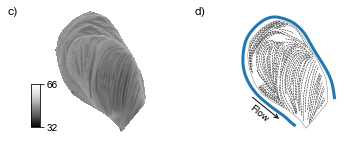

In [190]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2))

# DEM
dem[dem==0] = np.nan
ax1.imshow(dem, cmap="Greys_r")
ax1.set_axis_off()

# DEM colorbar
cax = fig.add_axes([0.15, 0.12, 0.02, 0.3])

cmap = mpl.cm.Greys_r

vmin = np.nanmin(dem)
vmax = np.nanmax(dem)
norm = mpl.colors.Normalize(vmin=vmin, vmax = vmax)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm, cmap),
                    cax=cax,
                    orientation='vertical')



cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(np.round([vmin, vmax]).astype(int))

# Skeleton
ridges.plot(ax=ax2, color="k", lw=0.5, ls="--", label="Ridges")
centerline.plot(ax=ax2, lw=3, label="Centerline")
bend.boundary.plot(ax=ax2, color="grey", lw=0.5)
ax2.set_axis_off()
# ax2.legend(loc="lower right", frameon=False)

# Add flow direction
line_piece = centerline.geometry.apply(lambda x: slice_line(x, 0.05, 0.2))
line_piece = line_piece.geometry.translate(xoff=-350, yoff=-150)

p1 = line_piece.geometry[0].coords[-1]
p2 = line_piece.geometry[0].coords[0]
ax2.annotate('', xy=(p2), xytext=(p1), arrowprops=dict(arrowstyle='->', linewidth=1))

anno_coords = line_piece.centroid.translate(xoff=-400, yoff=-300)[0].coords[0]
ax2.annotate("Flow", xy=(anno_coords), verticalalignment="center", horizontalalignment="center", rotation=rr_to_degrees(p1, p2))


# Add annotations
plt.text(0.1, 0.9, "c)", transform=fig.transFigure, size=12)
plt.text(0.5, 0.9, "d)", transform=fig.transFigure, size=12)

plt.tight_layout()
plt.savefig(f"BendIntro_{bend_id}.png", dpi=300)

In [191]:
bend_id = "BEA_002"
bend_ds = BendDataset(bend_id)
ridges = bend_ds.get_ridges(proj=True)
centerline = bend_ds.get_centerline(proj=True)
bend = bend_ds.get_bend(proj=True)

# dem = rasterio.open(RASTER_PATHS[bend_id]["dem"]).read(1)
# bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"]).read(1)

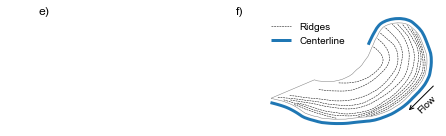

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2))


ax1.set_axis_off()

# Skeleton
ridges.plot(ax=ax2, color="k", lw=0.5, ls="--", label="Ridges")
centerline.plot(ax=ax2, lw=3, label="Centerline")
bend.boundary.plot(ax=ax2, color="grey", lw=0.5)
ax2.set_axis_off()
ax2.legend(loc="upper left", frameon=False)

# Add flow direction
line_piece = centerline.geometry.apply(lambda x: slice_line(x, 0.42, 0.55))
line_piece = line_piece.geometry.translate(xoff=50, yoff=-10)

p1 = line_piece.geometry[0].coords[0]
p2 = line_piece.geometry[0].coords[-1]
ax2.annotate('', xy=(p2), xytext=(p1), arrowprops=dict(arrowstyle='->', linewidth=1))

anno_coords = line_piece.centroid.translate(xoff=30, yoff=-30)[0].coords[0]
ax2.annotate("Flow", xy=(anno_coords), verticalalignment="center", horizontalalignment="center", rotation=rr_to_degrees(p1, p2))


# Add annotations
ax1.annotate("e)", (0.15,0.99), xycoords='axes fraction', size=12)
ax2.annotate("f)", (-0.15,0.99), xycoords='axes fraction', size=12)



# # Plot legend
# legend_elements = [Line2D([0], [0], color="tab:blue", lw=1.5, label='centerline'),
#                    Line2D([0], [0], color="k", lw=0.3, ls="--", label='ridges')]
# ax1.legend(handles=legend_elements, loc='center')


plt.tight_layout()
plt.savefig(f"BendIntro_{bend_id}.png", dpi=300)

In [105]:
cbar_locs = {
    "LBR_025": {
        "xmin": 0.81,
        "ymin": 0.74
        },
    "LBR_029": {
        "xmin": 0.53,
        "ymin": 0.78
        },
    "LBR_043": {
        "xmin": 0.21,
        "ymin": 0.43
        },
    "LBR_077": {
        "xmin": 0.68,
        "ymin": 0.45
        },
    "MIS_005": {
        "xmin": 0.71,
        "ymin": 0.13
        } 
}

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_22039/1799644542.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


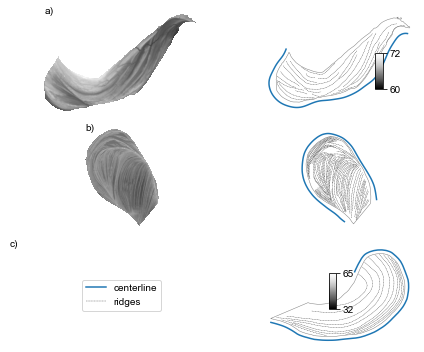

In [106]:
fig, axs = plt.subplots(3, 2, figsize=(6.5, 5))

lbr_bend_ids = sorted([i for i in bend_ids if i[:3]=="LBR"])
alpha_labels = "abcdef"

for i, bend_id in enumerate(bend_ids):
    # axs[i, 0].annotate(text=f"{bend_id} DEM", xy=(0.5, 0.5))
    # axs[i, 1].annotate(text=f"{bend_id} Skeleton", xy=(0.5, 0.5))


    # Find row number for bend
    # r_idx = i//2                   # 0, 0, 1, 1, 2, 2 ...\
    r_idx = i

    # Find column number for bend
    # c_idx_dem = (i%2)*2            # 0, 2, 0, 2, 0, 2 ...
    # c_idx_skel = c_idx_dem +1      # 1, 3, 1, 3, 1, 3 ...
    c_idx_dem = 0
    c_idx_skel = 1


    # Prepare the datasets
    # dem, bend, ridges, centerline = prepare_datasets(bend_id)

    bend_ds = BendDataset(bend_id)
    ridges = bend_ds.get_ridges(proj=True)
    centerline = bend_ds.get_centerline(proj=True)
    bend = bend_ds.get_bend(proj=True)

    dem_path = RASTER_PATHS[bend_id]["dem"]
    if dem_path == '':
        dem = None
    else:
        dem = rasterio.open(dem_path).read(1)
        dem[dem==0] = np.nan

    # DEM
    if isinstance(dem, np.ndarray):
        im = axs[r_idx, c_idx_dem].imshow(dem, cmap="Greys_r")
        axs[r_idx, c_idx_dem].set_axis_off()

        # Add colorbar
        # xmin, ymin, width, height = axs[r_idx, c_idx_dem].get_position().bounds
        # print(f"{bend_id}: (xmin: {xmin}, ymin: {ymin}, width: {width}, height: {height})")
        cax = plt.axes([cbar_locs[bend_id]["xmin"], cbar_locs[bend_id]["ymin"], 0.015, 0.1])
        ticks = np.nanquantile(dem, [0, 1])
        cbar = plt.colorbar(mappable=im, cax=cax, cmap="Greys_r", ticks=ticks)
        cbar.ax.set_yticklabels(ticks.astype(int))

    # Skeleton
    ridges.plot(ax=axs[r_idx, c_idx_skel], color="k", lw=0.3, ls="--", label="Ridges")
    centerline.plot(ax=axs[r_idx, c_idx_skel], lw=1.5, label="Centerline")
    # if not bend_id.startswith("KLI"):
    #     bend = bend.simplify(5)
    bend.boundary.plot(ax=axs[r_idx, c_idx_skel], color="grey", lw=0.5)

    axs[r_idx, c_idx_skel].set_axis_off()
    # axs[r_idx, c_idx_skel].add_artist(ScaleBar(1, location="upper right", frameon=False))

    # Add subfigure titles
    axs[r_idx, c_idx_dem].annotate(f"{alpha_labels[i]})", (0.01,0.99), xycoords='axes fraction')



    # Set axis off
    axs[r_idx, c_idx_dem].set_axis_off()
    axs[r_idx, c_idx_skel].set_axis_off()


# -------------------------------------------------------------------------------------------
# Add custom legend
legend_elements = [Line2D([0], [0], color="tab:blue", lw=1.5, label='centerline'),
                   Line2D([0], [0], color="k", lw=0.3, ls="--", label='ridges')]
axs[2, 0].legend(handles=legend_elements, loc='center')


# fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
# plt.savefig('../figures/BendIntroductionPlot_multi.png', dpi=300)

In [113]:
fig.transFigure